In [1]:
%config IPCompleter.greedy = True

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np

import pickle
import gzip
import h5py
import scipy

import sklearn
import sklearn.datasets

from PIL import Image
from scipy import ndimage

import matplotlib.pyplot as plt
%matplotlib inline

### 1. Load MNIST Data
***

In [4]:
def load_data():
    f = gzip.open('mnist.pkl.gz', 'rb')
    f.seek(0)
    
    training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
    
    f.close()

    return (training_data, validation_data, test_data)

Let's see how the data looks:

In [5]:
training_data, validation_data, test_data = load_data()

In [6]:
training_data

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([5, 0, 4, ..., 8, 4, 8], dtype=int64))

In [7]:
# shape of data
print(training_data[0].shape)
print(training_data[1].shape)

(50000, 784)
(50000,)


In [8]:
print("Feature dataset : {}".format(training_data[0]))
print("Target dataset : {}\n".format(training_data[1]))

print("Number of examples in the training dataset : {}".format(len(training_data[0])))
print("Number of points in a single input : {}\n".format(len(training_data[0][1])))

print("Number of elements in the target dataset : {}".format(len(training_data[1])))

Feature dataset : [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Target dataset : [5 0 4 ... 8 4 8]

Number of examples in the training dataset : 50000
Number of points in a single input : 784

Number of elements in the target dataset : 50000


> -  *Number of images present in the training dataset : 50,000*
-  *Each image is represented by 784 data points representing a 28 X 28 image*
-  *Each element in target dataset represents expected image label*

### 2. Data Preparation
***

Convert output image label into one-hot encoded column vectors

In [9]:
def one_hot(j):
    # get the number of elements in the input array
    n = j.shape[0]

    # creates a 10 X n array 
    # each row represents a digit i.e. 10 rows (0 - 9)
    # each column represents an input
    new_array = np.zeros((10, n))

    index = 0

    for res in j:
        new_array[res][index] = 1.0
        index = index + 1
    
    return new_array

Convert datasets into desired shapes and the ground truth labels to one_hot matrix

In [10]:
def data_wrapper(tr_d, va_d, te_d):

    # transpose input matrix so that each input is represented by a column vector
    training_inputs = np.array(tr_d[0][:]).T
    validation_inputs = np.array(va_d[0][:]).T
    test_inputs = np.array(te_d[0][:]).T

    # generate one-hot encoded matrix for output labels
    training_results = np.array(tr_d[1][:])
    train_set_y = one_hot(training_results)

    validation_results = np.array(va_d[1][:])
    validation_set_y = one_hot(validation_results)

    test_results = np.array(te_d[1][:])
    test_set_y = one_hot(test_results)

    return (training_inputs, train_set_y, test_inputs, test_set_y)

In [11]:
train_set_x, train_set_y, test_set_x, test_set_y = data_wrapper(
    training_data, validation_data, test_data)

In [12]:
print ("train_set_x shape: " + str(train_set_x.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x shape: (784, 50000)
train_set_y shape: (10, 50000)
test_set_x shape: (784, 10000)
test_set_y shape: (10, 10000)


We can see that the data_wrapper has converted the training and validation data into numpy array of desired shapes. Let's convert the actual labels into a dataframe to see if the one hot conversions are correct.

In [13]:
y = pd.DataFrame(train_set_y)

In [14]:
print("The target dataset is:" + str(training_data[1]))
print("The one hot encoding dataset is:")
y

The target dataset is:[5 0 4 ... 8 4 8]
The one hot encoding dataset is:


,0,1,2,3,4,5,6,7,8,9,...,49990,49991,49992,49993,49994,49995,49996,49997,49998,49999
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now let us visualise the dataset. Feel free to change the index to see if the training data has been correctly tagged.

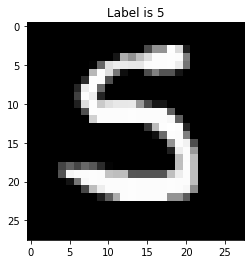

In [15]:
index  = 49991
k = train_set_x[:,index]
k = k.reshape((28, 28))
plt.title('Label is {label}'.format(label= training_data[1][index]))
plt.imshow(k, cmap='gray')

### 3. Activation Functions
***

### sigmoid
It takes a cumulative input into the layer, the matrix __Z__, as the input. Upon application of `sigmoid` function, the output matrix **H** is calculated. Also, Z is stored as the variable sigmoid_memory since it will be later used in backpropagation. You use _[np.exp()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.exp.html)_ here in the following way. The exponential gets applied to all the elements of Z.

In [16]:
def sigmoid(Z):

    # Z is numpy array of shape (n, m) where n is number of neurons in the layer and m is the number of samples
    # sigmoid_memory is stored as it is used later on in backpropagation

    H = 1 / (1 + np.exp(-Z))

    sigmoid_memory = Z

    return H, sigmoid_memory

In [17]:
# 4 neurons in a layer, 2 input data points
Z = np.arange(8).reshape(4, 2)
H, sigmoid_memory = sigmoid(Z)

# output of 1st input data points
print(H[:, 0])

# output of top neuron
print(H[0, :])

[0.5        0.88079708 0.98201379 0.99752738]
[0.5        0.73105858]


### relu
It takes the cumulative input to the layer, matrix **Z** as the input. Upon application of the `relu` function, matrix __H__ which is the output matrix is calculated. Also, Z is stored as `relu_memory` which will be later used in backpropagation. You use _[np.maximum()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.maximum.html)_ here in the following way.

In [18]:
def relu(Z):
    # Z is numpy array of shape (n, m) where n is number of neurons in the layer and m is the number of samples
    # relu_memory is stored as it is used later on in backpropagation

    H = np.maximum(0, Z)

    assert (H.shape == Z.shape)

    relu_memory = Z
    return H, relu_memory

In [19]:
# 4 neurons in a layer, 2 input data points
Z = np.array([1, 3, -1, -4, -5, 7, 9, 18]).reshape(4, 2)

H, relu_memory = relu(Z)

# cumulative input to the layer
print("cumulative input (Z) : {}\n".format(relu_memory))

# output of relu activation function
print("output : {}".format(H))

cumulative input (Z) : [[ 1  3]
 [-1 -4]
 [-5  7]
 [ 9 18]]

output : [[ 1  3]
 [ 0  0]
 [ 0  7]
 [ 9 18]]


### softmax
It takes the cumulative input to the layer, matrix **Z** as the input. Upon application of the `softmax` function, the output matrix __H__ is calculated. Also, Z is stored as `softmax_memory` which will be later used in backpropagation. You use _[np.exp()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.exp.html)_ and _[np.sum()](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.sum.html)_ here in the following way. The exponential gets applied to all the elements of Z.

In [20]:
def softmax(Z):
    # Z is numpy array of shape (n, m) where n is number of neurons in the layer and m is the number of samples
    # softmax_memory is stored as it is used later on in backpropagation

    Z_exp = np.exp(Z)
    Z_sum = np.sum(Z_exp, axis=0, keepdims=True)

    H = Z_exp / Z_sum  #normalising step
    softmax_memory = Z

    return H, softmax_memory

In [21]:
# output layer is made of 10 neurons, testing with 3 input data points
Z = np.array(np.arange(30)).reshape(10,3)

H, softmax_memory = softmax(Z)

# cumulative input to the layer
print("cumulative input (Z) : {}\n".format(softmax_memory))

# output of softmax activation function
print("output : {}".format(H))

cumulative input (Z) : [[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]
 [15 16 17]
 [18 19 20]
 [21 22 23]
 [24 25 26]
 [27 28 29]]

output : [[1.78595259e-12 1.78595259e-12 1.78595259e-12]
 [3.58718166e-11 3.58718166e-11 3.58718166e-11]
 [7.20504697e-10 7.20504697e-10 7.20504697e-10]
 [1.44717237e-08 1.44717237e-08 1.44717237e-08]
 [2.90672341e-07 2.90672341e-07 2.90672341e-07]
 [5.83831003e-06 5.83831003e-06 5.83831003e-06]
 [1.17265592e-04 1.17265592e-04 1.17265592e-04]
 [2.35534237e-03 2.35534237e-03 2.35534237e-03]
 [4.73083162e-02 4.73083162e-02 4.73083162e-02]
 [9.50212932e-01 9.50212932e-01 9.50212932e-01]]


### 4. FeedForward
***

### initialize_parameters
Let's now create a function **`initialize_parameters`** which initializes the weights and biases of the various layers.

The inputs to this function is a list named `dimensions`. The length of the list is the number layers in the network + 1 (the plus one is for the input layer, rest are hidden + output). The first element of this list is the dimensionality or length of the input (784 for the MNIST dataset). The rest of the list contains the number of neurons in the corresponding (hidden and output) layers.

For example `dimensions = [784, 3, 7, 10]` specifies a network for the MNIST dataset with two hidden layers and a 10-dimensional softmax output.

In [22]:
def initialize_parameters(dimensions):

    # dimensions is a list containing the number of neuron in each layer in the network
    # It returns parameters which is a python dictionary containing the parameters "W1", "b1", ..., "WL", "bL":

    np.random.seed(2)
    parameters = {}
    L = len(dimensions)

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(dimensions[l],
                                                   dimensions[l - 1]) * 0.1
        parameters['b' + str(l)] = np.zeros((dimensions[l], 1))

        assert (parameters['W' + str(l)].shape == (dimensions[l],
                                                   dimensions[l - 1]))
        assert (parameters['b' + str(l)].shape == (dimensions[l], 1))

    return parameters

### layer_forward

The function **`layer_forward`** implements the forward propagation for a certain layer 'l'. 

It calculates the cumulative input into the layer **Z** and uses it to calculate the output of the layer __H__. It takes H_prev, W, b and the activation function as inputs and stores the linear_memory, activation_memory in the variable memory which will be used later in backpropagation.

In [23]:
def layer_forward(H_prev, W, b, activation='relu'):

    # H_prev is of shape (size of previous layer, number of examples)
    # W is weights matrix of shape (size of current layer, size of previous layer)
    # b is bias vector of shape (size of the current layer, 1)
    # activation is the activation to be used for forward propagation : "softmax", "relu", "sigmoid"

    # H is the output of the activation function
    # memory is a python dictionary containing "linear_memory" and "activation_memory"

    linear_memory = (H_prev, W, b)

    Z = np.dot(W, H_prev) + b

    if activation == "sigmoid":
        H, activation_memory = sigmoid(Z)

    elif activation == "softmax":
        H, activation_memory = softmax(Z)

    elif activation == "relu":
        H, activation_memory = relu(Z)

    memory = (linear_memory, activation_memory)

    return H, memory

### L_layer_forward

**`L_layer_forward`** performs one forward pass through the whole network for all the training samples (note that we are feeding all training examples in one single batch).

In [24]:
def L_layer_forward(X, parameters):

    # X is input data of shape (input size, number of examples)
    # parameters is output of initialize_parameters()
    
    # HL is the last layer's post-activation value
    # memories is the list of memory containing (for a relu activation, for example):
    # - every memory of relu forward (there are L-1 of them, indexed from 1 to L-1), 
    # - the memory of softmax forward (there is one, indexed L) 

    memories = []
    H = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement relu layer (L-1) times as the Lth layer is the softmax layer
    for l in range(1, L):
        H_prev = H
        
        H, memory = layer_forward(H_prev, parameters['W' + str(l)], parameters['b' + str(l)], "relu")
        
        memories.append(memory)
    
    # Implement the final softmax layer
    # HL here is the final prediction P as specified in the lectures
    HL, memory = layer_forward(H, parameters['W' + str(L)], parameters['b' + str(L)], "softmax")
    
    memories.append(memory)

    assert(HL.shape == (10, X.shape[1]))
            
    return HL, memories

### 5. Network Loss
***